In [1]:
import os
import pandas as pd
import numpy as np
import py3Dmol
import matplotlib.pyplot as plt

from rdkit import RDConfig
from rdkit.Chem.FeatMaps import FeatMaps

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import rdMolAlign
from rdkit.Chem.Pharm2D import Generate
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Features.ShowFeats import _featColors as featColors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdmolops

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 

import time
print(time.asctime())
from rdkit import rdBase
print(rdBase.rdkitVersion)

Fri Sep  1 13:40:31 2023
2023.03.2


In [ ]:
def draw3D(ms, p=None, confId=-1, removeHs=True,colors=('cyanCarbon','redCarbon','blueCarbon')):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        if removeHs:
            m = Chem.RemoveHs(ms)
        IPythonConsole.addMolToView(m,p,confId=confId)

        p.setStyle({'stick':{}})#{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

In [ ]:
def colorToHex(rgb):
    rgb = [int(x*255) for x in rgb]
    #print(rgb)
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])
    #return '0x'+''.join(rgb)
def drawit(m, feats, p=None, confId=-1, removeHs=True):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        if removeHs:
            m = Chem.RemoveHs(m)
        IPythonConsole.addMolToView(m,p,confId=confId)
        visited_positions = [np.array([None, None, None])]
        for feat in feats:
            pos = feat.GetPos()
            if np.any(np.all(np.array(pos) == np.array(visited_positions), axis=1)):
                r = .5
                print("now")
            else:
                r = .5
            #r=.5
            visited_positions.append(np.array(pos))
            print(np.array(pos))
            clr = featColors.get(feat.GetFamily(),(.5,.5,.5))
            print(feat.GetFamily(), clr)
            #print(colorToHex(clr))
            p.addSphere({'center':{'x':pos.x,'y':pos.y,'z':pos.z},'radius':r,'color':colorToHex(clr), 'opacity':0.95});
        p.zoomTo()
        return p.show()

In [ ]:
def drawFeatMap(m, fMap, p=None, confId=-1, removeHs=True):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        if removeHs:
            m = Chem.RemoveHs(m)
        IPythonConsole.addMolToView(m,p,confId=confId)
        for feat in fMap.GetFeatures():
            pos = feat.GetPos()
            clr = featColors.get(feat.GetFamily(),(.5,.5,.5))
            p.addSphere({'center':{'x':pos.x,'y':pos.y,'z':pos.z},'radius':feat.weight*.5,'color':colorToHex(clr)});
        p.zoomTo()
        return p.show()

In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem.Pharm2D import Generate
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem import ChemicalFeatures
#from rdkit import DataStructs

fdefName = 'BaseFeatures.fdef'

class Pharma2D:
    def __init__(self, smiles, titles, bins = [(0,3),(3,8)]):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles
        self.titles = titles
        
        featFactory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))
        sigFactory = SigFactory(featFactory, minPointCount=2, maxPointCount=3, trianglePruneBins=False)
        sigFactory.SetBins(bins) #try both 2 and three bins
        sigFactory.skipFeats=['ZnBinder', 'Hydrophobe', 'LumpedHydrophobe']
        sigFactory.Init()
        
        self.Nbits = sigFactory.GetSigSize()
        self.sigFactory = sigFactory
        print(self.Nbits)

    def mol2fp(self, mol):
        
        fp = np.array(Generate.Gen2DFingerprint(mol, self.sigFactory))
        
        return fp

    def compute_pharma2D(self, name):
        bit_headers = ['bit' + str(i) for i in range(self.Nbits)]
        arr = np.empty((0,self.Nbits), int).astype(int)
        for i in self.mols:
            fp = self.mol2fp(i)
            arr = np.vstack((arr, fp))
        df_pharma2D = pd.DataFrame(np.asarray(arr).astype(int),columns=bit_headers)
        df_pharma2D.insert(loc=0, column='smiles', value=self.smiles)
        df_pharma2D.insert(loc=0, column='title', value=self.titles)
        df_pharma2D.to_csv(name, index=False)


### Cleaning of data

In [ ]:
import pandas as pd
df_smiles = pd.read_csv("HLL10K.csv")
df_smiles

In [ ]:
df = pd.read_csv('6ETI_glide_ligprep_xp.csv')
df["SMILES"] = df_smiles.SMILES

In [ ]:
df.drop(df[df.r_i_docking_score >= 0].index, inplace=True)
df.drop(df[df.r_i_docking_score.isna()].index, inplace=True)
df.sort_values(by="r_i_docking_score", ascending=True, inplace=True, ignore_index=True)
df.drop_duplicates(subset="title", inplace=True, keep="first")
df

In [ ]:
df.to_csv('6ETI_glide_ligprep_xp_cleaned.csv')

### Generating 2D pharmacophore descriptors

In [ ]:
df = pd.read_csv('6ETI_glide_ligprep_xp_cleaned.csv', index_col=0)
pharma2D_descriptor = Pharma2D(list(df.SMILES), list(df.title), bins = [(0,3), (3,8)])
pharma2D_descriptor.compute_pharma2D("6ETI_glide_ligprep_xp_cleaned_pharma2D_A.csv")

### Generating FMVs (3D pharmacophore descriptors) from feature maps

The FMVs require reference feature maps from a selection of molecules - these are chosen so that all features are represented. See code below. The strctures are saved in .sdf files so the reference molecules do not need to be recomputed. When calculating feature maps we need to define which features weare interested in.

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

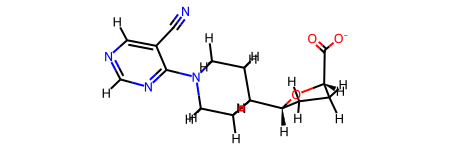

In [2]:
ref1 = Chem.MolFromMolFile("ref_mol_1.sdf", removeHs=False)
ref2 = Chem.MolFromMolFile("ref_mol_2.sdf", removeHs=False)
ref3 = Chem.MolFromMolFile("ref_mol_3.sdf", removeHs=False)
low_conf_ref_mols = [ref1, ref2, ref3]
ref1

In [3]:
features = ('Donor','Acceptor','NegIonizable','PosIonizable','Aromatic', 'Hydrophobe') #with ot without hydrophobe
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))
fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

In [4]:
def get_fmv(mol, features, fdef, fmParams):    
    #featLists = []
    #for m in low_conf_ref_mols:
    #    rawFeats = fdef.GetFeaturesForMol(m)
    #    # filter that list down to only include the ones we're intereted in 
    #    featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    
    rawFeats = fdef.GetFeaturesForMol(mol)
    feats = [f for f in rawFeats if f.GetFamily() in features]
    feature_map = FeatMaps.FeatMap(feats = feats,weights=[1]*len(feats),params=fmParams)
    return feature_map


In [5]:
ref_fms = [get_fmv(m, features, fdef, fmParams) for m in low_conf_ref_mols]
ref_fms

To generature the feature map vectors we choose the conformer of each molecule that maximizes feature-map overlap to each of the reference molecules (after alignment). The three FMVs (one for each reference) are combined to a final molecular representation. get_max_fmv calculates this combined FMV from smiles and reference mols/feature maps.  

In [6]:
def get_max_fmv(smiles, ref_mols, ref_featmaps, features, fmParams):
    
    ps = AllChem.ETKDGv3()
    mol = Chem.MolFromSmiles(smiles)
 
    charge = Chem.GetFormalCharge(mol)
    
    nrot = rdMolDescriptors.CalcNumRotatableBonds(mol)
    nconfs = 5+5*nrot
    #print(nconfs)

    mol = Chem.AddHs(mol)
    rdmolops.AssignStereochemistry(mol)
    confs = AllChem.EmbedMultipleConfs(mol, numConfs=nconfs, params=ps)
    res = AllChem.MMFFOptimizeMoleculeConfs(mol)
    #featmap_scores = []
    fmv = np.array([])
    for ref_mol, ref_featmap in zip(ref_mols, ref_featmaps):
        max_score = 0
        for i in range(mol.GetNumConformers()):
            #align to reference mol
            o3d = rdMolAlign.GetO3A(mol,ref_mol,prbCid=i)
            o3d.Align()
            #find features in mol
            feature_list = fdef.GetFeaturesForMol(mol, confId=i)
            # filter that list down to only include the ones we're intereted in 
            feature_list = [f for f in feature_list if f.GetFamily() in features]
            #generate featmap
            feat_map = FeatMaps.FeatMap(feats = feature_list,weights=[1]*len(feature_list),params=fmParams)
    
            featmap_score = ref_featmap.ScoreFeats(feat_map.GetFeatures())/ref_featmap.GetNumFeatures()
            #print(featmap_score)
            #featmap_scores.append(featmap_score)
            if featmap_score > max_score:
                max_score = featmap_score
                scoreVect = [0]*ref_featmap.GetNumFeatures()
                ref_featmap.ScoreFeats(feature_list,mapScoreVect=scoreVect)
                #print(scoreVect)
        fmv = np.append(fmv, scoreVect)
    return fmv

In [7]:
N_feats = sum([len(x._feats) for x in ref_fms])
print("Total number of features in the combined FMV = ", N_feats)

Total number of features in the combined FMV =  47


Since the FMVs can take some time to compute due to the conformational search done, I set it up to continue from a csv where some of the fmvs were already computed. Starting from the beginning would just mean start_idx = 0

In [22]:
current_fmv_df = pd.read_csv("fmvs+hydrophobe.csv")
start_idx = len(current_fmv_df)
current_fmv_df[-10:]

,smiles,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,...,fp37,fp38,fp39,fp40,fp41,fp42,fp43,fp44,fp45,fp46
1000,Cc1cccc(N2C(=O)N[C@H](CCC(=O)N3Cc4ccccc4-c4ccc...,0.004394,0.925640,0.00000,0.000000,0.0,0.000000,1.022317,1.221597,1.104349,...,0.906351,0.000000,0.005539,1.307613,0.963437,1.194292,0.092834,0.293916,0.652214,0.008660
1001,C[C@@]1(C(=O)N[C@@H]2CC(=O)N([C@@H]3C[C@@H]3c3...,0.002155,0.870616,0.00000,0.671488,0.0,0.000000,0.834578,0.002973,0.145781,...,0.000000,0.000000,0.000000,0.932823,0.194827,0.115122,0.473276,0.497501,0.540985,0.933076
1002,Nc1noc2cc(CNC(=O)[C@H]3CC34CCCC4)ccc12,0.009394,0.000000,0.00000,0.000000,0.0,0.991518,1.222572,0.139067,0.865636,...,0.782446,0.000000,0.991593,1.195128,1.210479,0.283583,0.941833,0.545480,0.005764,1.161599
1003,CCCNC(=O)[C@@H](C)NC(=O)NCc1cccc(Oc2ccccc2F)c1,0.008166,0.737625,0.03403,0.490442,0.0,0.000000,0.000000,0.052994,0.854244,...,0.019623,0.000000,0.831770,0.936328,1.312383,0.413313,0.874820,0.000000,0.000000,0.000000
1004,Cc1nc(C(=O)N[C@H](CO)Cc2ccccc2)nn1-c1nnc(C(F)(...,0.102542,0.996894,0.00000,0.000000,0.0,0.922806,0.000000,0.086153,1.054181,...,0.978716,0.955743,0.006639,0.126338,0.180891,1.316214,0.535515,0.981881,0.109184,0.072208
1005,CCNC(=O)[C@@H](Cc1ccccc1)NC(=O)c1ccccc1,0.000000,0.000000,0.00000,0.000000,0.0,0.977335,1.065378,0.210189,0.506197,...,0.006252,0.000000,0.982916,1.271021,1.220379,1.267193,0.984677,1.266759,0.726743,0.377530
1006,Cn1c(=O)[nH]c2ccc(C(=O)N[C@@H]3CCN(C(=O)C4CCCC...,0.008245,0.930804,0.00000,0.662791,0.0,0.000000,1.216319,0.002572,0.005817,...,0.011615,0.000000,0.982205,1.221329,1.167050,0.229746,1.161435,0.462845,0.025473,0.865875
1007,CC(C)c1cc(C(=O)N(C)Cc2cccc3ccccc23)n[nH]1,0.004230,0.039484,0.00000,0.000000,0.0,0.890103,0.003608,0.040886,1.161836,...,0.000000,0.922933,0.007514,0.971819,1.014925,0.002386,0.010933,1.038786,0.317648,1.072913
1008,C[C@](O)(CNC(=O)c1c[nH]c(=O)c(C(F)(F)F)c1)c1cc...,0.000000,0.000000,0.00000,0.000000,0.0,0.984197,1.259258,0.000000,0.097558,...,0.000000,0.000000,0.000000,0.124894,0.004376,1.023243,1.289237,0.991110,0.239525,0.985398
1009,O=C(c1ccc(F)c2occc12)N1CCC[C@@H](N2CCNC2=O)C1,0.002481,0.896867,0.78022,0.000000,0.0,0.004790,1.112464,0.066657,0.244033,...,0.030929,0.000000,0.964921,1.165264,1.082197,0.247181,1.183634,0.000000,0.000000,0.000000


In [ ]:
fmvs = []
for i, smiles in enumerate(df.SMILES):
    if i >= start_idx and i < start_idx+500:
        print(i)
        try:
            score_vect = get_max_fmv(smiles, low_conf_ref_mols, ref_fms, features, fmParams)
            #print(score_vect)
        except:
            print("failed")
            score_vect = [np.nan]*N_feats
            #max_featmap_score = np.nan
        fmvs.append(score_vect)

1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209


In [ ]:
df = pd.read_csv("6ETI_glide_ligprep_xp_cleaned.csv", index_col=0)
df = df.reset_index()
df = df[["title", "SMILES"]]

df_temp = pd.read_csv("fmvs+hydrophobe.csv")
#df_temp = pd.DataFrame() #use an empty dataframe if not continuing previous
df_temp

In [ ]:
fp_headers = ['fp' + str(i) for i in np.arange(0, N_feats)]
#arr = np.empty((0,N_feats), float).astype(float) #use this is df_temp is empty dataframe
arr = df_temp.drop('smiles', axis=1).values
for fp in fmvs:
    #print(fp)
    arr = np.vstack((arr, fp))
df_fmvs = pd.DataFrame(np.asarray(arr).astype(float),columns=fp_headers)
df_fmvs.insert(loc=0, column='smiles', value=list(df.SMILES)[:(len(df_temp)+len(fmvs))])
df_fmvs.to_csv("fmvs+hydrophobe.csv", index=False)

### Choosing reference molecules for FMVs with kmeans clustering

In [ ]:
df = pd.read_csv("6ETI_glide_ligprep_xp_cleaned.csv", index_col=0)
df = df.reset_index()
df_pharma2D = pd.read_csv("6ETI_glide_ligprep_xp_cleaned_pharma2D_A.csv")
arr_fp = df_pharma2D.drop(['title', 'smiles'], axis=1).values
df_fp = df[["title", "SMILES"]]

In [ ]:
kmean = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmean.fit(arr_fp)
label = kmean.labels_

In [ ]:
colormaps = {0:'red',1:'blue',2:'green',3:'orange',4:'yellow'}
kmeanc = [colormaps[i] for i in kmean.labels_]

pca = PCA(2)
df = pd.DataFrame(pca.fit_transform(arr_fp))
df

In [ ]:
def get_FMV_features(data_ids):
    data_ids = [num for num in data_ids if isinstance(num, (int))]
    print(data_ids)
    ref_mols = [Chem.MolFromSmiles(df_fp.loc[i, 'SMILES']) for i in data_ids]
    ref_mols = [Chem.AddHs(m) for m in ref_mols]
    ps = AllChem.ETKDGv3()
    ps.randomSeed = 0xf00d  # we seed the RNG so that this is reproducible
    for m in ref_mols:
        AllChem.EmbedMolecule(m,ps)
        
    fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))
    #print(fdef.GetFeatureFamilies())
    
    fmParams = {}
    for k in fdef.GetFeatureFamilies():
        fparams = FeatMaps.FeatMapParams()
        fmParams[k] = fparams
        
    keep = ('Donor','Acceptor','NegIonizable','PosIonizable','Aromatic')
    featLists = []
    
    for m in ref_mols:
        rawFeats = fdef.GetFeaturesForMol(m)
        # filter that list down to only include the ones we're intereted in 
        featLists.append([f.GetFamily() for f in rawFeats if f.GetFamily() in keep])
    
    feats_union = set().union(*featLists)
    print(feats_union)
    return len(feats_union)

In [ ]:
centers = np.array(kmean.cluster_centers_)
num_clusters = 3
k_closest = [0,0,0]
closest_data = []
n_feats = 0
while n_feats < 5:
    for i in range(num_clusters):
        center_vec = centers[i]
        data_idx_within_i_cluster = [ idx for idx, clu_num in enumerate(label) if clu_num == i ]

        one_cluster_tf_matrix = np.zeros( (  len(data_idx_within_i_cluster) , centers.shape[1] ) )
        for row_num, data_idx in enumerate(data_idx_within_i_cluster):
            one_row = arr_fp[data_idx]
            one_cluster_tf_matrix[row_num] = one_row

        closest, _ = pairwise_distances_argmin_min(center_vec.reshape(1,-1), one_cluster_tf_matrix)
        closest2 = pairwise_distances(center_vec.reshape(1,-1), one_cluster_tf_matrix)[0]
        print("closest", closest)
        closest_idx_in_one_cluster_tf_matrix = np.argsort(closest2)[k_closest[i]]
        print(closest_idx_in_one_cluster_tf_matrix)
        print(closest2[closest[0]], closest2[closest_idx_in_one_cluster_tf_matrix])
        #closest_idx_in_one_cluster_tf_matrix = closest[k_closest[i]]
        closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_tf_matrix]
        data_id = df.index.to_list()[closest_data_row_num]
        k_closest[i] += 1
        print(k_closest)

        if len(closest_data) < num_clusters:
            closest_data.append(data_id)
            n_feats = get_FMV_features(closest_data)
            continue
        
        closest_data_temp = closest_data.copy()
        closest_data_temp[i] = data_id
        n_feats_temp = get_FMV_features(closest_data_temp)    
        if n_feats_temp > n_feats:
            closest_data[i] = data_id
            n_feats = n_feats_temp

In [ ]:
#closest_data = [3757, 561, 8058] #should be result of above run
closest_data

In [ ]:
#filter rows of original data
filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
filtered_label2 = df[label == 2]
    
#plotting the results
plt.scatter(filtered_label0.loc[:,0] , filtered_label0.loc[:,1], s=5, alpha=0.6, color='red')
plt.scatter(filtered_label1.loc[:,0] , filtered_label1.loc[:,1], s=5, alpha=0.6, color='blue')
plt.scatter(filtered_label2.loc[:,0] , filtered_label2.loc[:,1], s=5, alpha=0.6, color='green')
plt.scatter(df.loc[closest_data].loc[:,0], df.loc[closest_data].loc[:,1], s=50, alpha=0.6, color='k')
plt.xlabel("PCA_0")
plt.ylabel("PCA_1")
plt.savefig("kmeans_plot3.pdf")
plt.show()

In [ ]:
ref_mols = [Chem.MolFromSmiles(df_fp.loc[i, 'SMILES']) for i in closest_data]
ref_mols = [Chem.AddHs(m) for m in ref_mols]
low_conf_ref_mols = []
ps = AllChem.ETKDGv3()
ps.randomSeed = 0xf00d  # we seed the RNG so that this is reproducible
for m in ref_mols:
    Nrot = Chem.rdMolDescriptors.CalcNumRotatableBonds(m)
    Nconf = 5 + 5*Nrot
    AllChem.EmbedMultipleConfs(m, numConfs=Nconf, params=ps)
    energies = AllChem.MMFFOptimizeMoleculeConfs(m)
    energies = [e[1] for e in energies]
    low_e_conf_id = np.argmin(energies)
    print(low_e_conf_id)
    new_mol = Chem.Mol(m)
    new_mol.RemoveAllConformers()
    low_e_conf = m.GetConformer(int(low_e_conf_id))
    new_mol.AddConformer(low_e_conf)
    low_conf_ref_mols.append(new_mol)

The three reference mol structures including all 5/6 features are written to file so one doesn't need to repeat hisprocedure every time we want to calculate fingerprints

In [ ]:
#writer = Chem.SDWriter('ref_mol_3.sdf')
#writer.write(low_conf_ref_mols[2])